In [2]:
pip install torch torchvision efficientnet-pytorch tqdm scikit-learn seaborn matplotlib

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=415ee911fc1bd4f3c466f1e51788288800e21c3eb00ffe38a98c131dab6fe7a5
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch
Note: you may need to restart the kernel to use updated packages.


# Training

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from efficientnet_pytorch import EfficientNet
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

class CTScanClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CTScanClassifier, self).__init__()
        # Load pre-trained EfficientNetB0
        self.efficient_net = EfficientNet.from_pretrained('efficientnet-b0')
        # Modify the classifier
        num_ftrs = self.efficient_net._fc.in_features
        self.efficient_net._fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_ftrs, num_classes)
        )
    
    def forward(self, x):
        return self.efficient_net(x)

def create_dataloaders(data_path, batch_size=32):
    # Data transforms
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'valid': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }
    
    # Create datasets
    image_datasets = {
        x: ImageFolder(os.path.join(data_path, x), data_transforms[x])
        for x in ['train', 'valid', 'test']
    }
    
    # Create dataloaders
    dataloaders = {
        x: DataLoader(image_datasets[x], batch_size=batch_size,
                     shuffle=True if x == 'train' else False,
                     num_workers=4)
        for x in ['train', 'valid', 'test']
    }
    
    return dataloaders, image_datasets

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    best_acc = 0.0
    best_model_wts = None
    
    # For plotting
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.cpu())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.cpu())
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict().copy()
                # Save checkpoint
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_acc': best_acc,
                }, f'checkpoint_epoch_{epoch}.pth')
    
    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accs, val_accs

def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model = model.to(device)
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, 
                              target_names=test_loader.dataset.classes))
    
    return cm, all_preds, all_labels

def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.close()

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.close()

def main():
    # Set random seed for reproducibility
    torch.manual_seed(42)
    
    # Hyperparameters
    BATCH_SIZE = 32
    NUM_EPOCHS = 25
    LEARNING_RATE = 0.001
    
    # Create dataloaders
    dataloaders, image_datasets = create_dataloaders("/kaggle/input/chest-ctscan-images/Data", BATCH_SIZE)
    
    # Create model
    num_classes = len(image_datasets['train'].classes)
    model = CTScanClassifier(num_classes)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
    
    # Train model
    model, train_losses, val_losses, train_accs, val_accs = train_model(
        model, dataloaders, criterion, optimizer, scheduler, NUM_EPOCHS
    )
    
    # Plot training curves
    plot_training_curves(train_losses, val_losses, train_accs, val_accs)
    
    # Evaluate on test set
    cm, preds, labels = evaluate_model(model, dataloaders['test'])
    
    # Plot confusion matrix
    plot_confusion_matrix(cm, image_datasets['test'].classes)

if __name__ == "__main__":
    main()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 302MB/s]


Loaded pretrained weights for efficientnet-b0
Epoch 1/25
----------


100%|██████████| 20/20 [00:06<00:00,  3.27it/s]


train Loss: 0.8709 Acc: 0.6427


100%|██████████| 3/3 [00:00<00:00,  4.07it/s]


valid Loss: 0.9908 Acc: 0.6111
Epoch 2/25
----------


100%|██████████| 20/20 [00:04<00:00,  4.21it/s]


train Loss: 0.4678 Acc: 0.8222


100%|██████████| 3/3 [00:00<00:00,  5.87it/s]


valid Loss: 1.0401 Acc: 0.5972
Epoch 3/25
----------


100%|██████████| 20/20 [00:04<00:00,  4.31it/s]


train Loss: 0.2805 Acc: 0.8972


100%|██████████| 3/3 [00:00<00:00,  5.39it/s]


valid Loss: 2.4630 Acc: 0.4444
Epoch 4/25
----------


100%|██████████| 20/20 [00:04<00:00,  4.33it/s]


train Loss: 0.1992 Acc: 0.9347


100%|██████████| 3/3 [00:00<00:00,  5.55it/s]


valid Loss: 1.1180 Acc: 0.6806
Epoch 5/25
----------


100%|██████████| 20/20 [00:04<00:00,  4.29it/s]


train Loss: 0.1524 Acc: 0.9494


100%|██████████| 3/3 [00:00<00:00,  5.81it/s]


valid Loss: 0.4967 Acc: 0.8611
Epoch 6/25
----------


100%|██████████| 20/20 [00:04<00:00,  4.23it/s]


train Loss: 0.1465 Acc: 0.9478


100%|██████████| 3/3 [00:00<00:00,  5.64it/s]


valid Loss: 1.4817 Acc: 0.7222
Epoch 7/25
----------


100%|██████████| 20/20 [00:04<00:00,  4.26it/s]


train Loss: 0.1122 Acc: 0.9641


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


valid Loss: 0.7243 Acc: 0.7778
Epoch 8/25
----------


100%|██████████| 20/20 [00:04<00:00,  4.02it/s]


train Loss: 0.0489 Acc: 0.9853


100%|██████████| 3/3 [00:00<00:00,  5.99it/s]


valid Loss: 1.6050 Acc: 0.6944
Epoch 9/25
----------


100%|██████████| 20/20 [00:04<00:00,  4.24it/s]


train Loss: 0.0650 Acc: 0.9772


100%|██████████| 3/3 [00:00<00:00,  5.70it/s]


valid Loss: 1.4906 Acc: 0.6528
Epoch 10/25
----------


100%|██████████| 20/20 [00:04<00:00,  4.24it/s]


train Loss: 0.0509 Acc: 0.9853


100%|██████████| 3/3 [00:00<00:00,  5.76it/s]


valid Loss: 1.4789 Acc: 0.6944
Epoch 11/25
----------


100%|██████████| 20/20 [00:04<00:00,  4.23it/s]


train Loss: 0.1006 Acc: 0.9723


100%|██████████| 3/3 [00:00<00:00,  5.73it/s]


valid Loss: 3.0794 Acc: 0.5139
Epoch 12/25
----------


100%|██████████| 20/20 [00:04<00:00,  4.21it/s]


train Loss: 0.0716 Acc: 0.9755


100%|██████████| 3/3 [00:00<00:00,  5.60it/s]


valid Loss: 1.0262 Acc: 0.7500
Epoch 13/25
----------


100%|██████████| 20/20 [00:04<00:00,  4.19it/s]


train Loss: 0.0480 Acc: 0.9837


100%|██████████| 3/3 [00:00<00:00,  5.69it/s]


valid Loss: 1.2911 Acc: 0.7083
Epoch 14/25
----------


100%|██████████| 20/20 [00:04<00:00,  4.01it/s]


train Loss: 0.0615 Acc: 0.9739


100%|██████████| 3/3 [00:00<00:00,  5.52it/s]


valid Loss: 3.2730 Acc: 0.5694
Epoch 15/25
----------


100%|██████████| 20/20 [00:04<00:00,  4.17it/s]


train Loss: 0.0187 Acc: 0.9967


100%|██████████| 3/3 [00:00<00:00,  5.93it/s]


valid Loss: 1.7969 Acc: 0.6111
Epoch 16/25
----------


100%|██████████| 20/20 [00:04<00:00,  4.13it/s]


train Loss: 0.0166 Acc: 0.9935


100%|██████████| 3/3 [00:00<00:00,  5.89it/s]


valid Loss: 1.8350 Acc: 0.6250
Epoch 17/25
----------


100%|██████████| 20/20 [00:04<00:00,  4.15it/s]


train Loss: 0.0182 Acc: 0.9951


100%|██████████| 3/3 [00:00<00:00,  6.14it/s]


valid Loss: 0.9868 Acc: 0.7361
Epoch 18/25
----------


100%|██████████| 20/20 [00:04<00:00,  4.12it/s]


train Loss: 0.0192 Acc: 0.9967


100%|██████████| 3/3 [00:00<00:00,  5.39it/s]


valid Loss: 0.6233 Acc: 0.7917
Epoch 19/25
----------


100%|██████████| 20/20 [00:04<00:00,  4.12it/s]


train Loss: 0.0242 Acc: 0.9935


100%|██████████| 3/3 [00:00<00:00,  5.19it/s]


valid Loss: 0.5805 Acc: 0.8194
Epoch 20/25
----------


100%|██████████| 20/20 [00:05<00:00,  3.93it/s]


train Loss: 0.0145 Acc: 0.9967


100%|██████████| 3/3 [00:00<00:00,  5.54it/s]


valid Loss: 0.2761 Acc: 0.9167
Epoch 21/25
----------


100%|██████████| 20/20 [00:04<00:00,  4.09it/s]


train Loss: 0.0276 Acc: 0.9869


100%|██████████| 3/3 [00:00<00:00,  5.65it/s]


valid Loss: 0.2916 Acc: 0.9028
Epoch 22/25
----------


100%|██████████| 20/20 [00:04<00:00,  4.11it/s]


train Loss: 0.0338 Acc: 0.9902


100%|██████████| 3/3 [00:00<00:00,  5.63it/s]


valid Loss: 0.2927 Acc: 0.9167
Epoch 23/25
----------


100%|██████████| 20/20 [00:04<00:00,  4.13it/s]


train Loss: 0.0138 Acc: 0.9967


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


valid Loss: 0.2930 Acc: 0.9167
Epoch 24/25
----------


100%|██████████| 20/20 [00:04<00:00,  4.14it/s]


train Loss: 0.0149 Acc: 0.9951


100%|██████████| 3/3 [00:00<00:00,  5.69it/s]


valid Loss: 0.2886 Acc: 0.9167
Epoch 25/25
----------


100%|██████████| 20/20 [00:04<00:00,  4.14it/s]


train Loss: 0.0132 Acc: 0.9967


100%|██████████| 3/3 [00:00<00:00,  4.59it/s]


valid Loss: 0.2909 Acc: 0.9167
Best val Acc: 0.916667


100%|██████████| 10/10 [00:01<00:00,  6.07it/s]



Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.91      0.95      0.93       120
   large.cell.carcinoma       0.92      0.94      0.93        51
                 normal       1.00      0.98      0.99        54
squamous.cell.carcinoma       0.98      0.92      0.95        90

               accuracy                           0.95       315
              macro avg       0.95      0.95      0.95       315
           weighted avg       0.95      0.95      0.95       315



# Test Inferences

Loaded pretrained weights for efficientnet-b0


<ipython-input-19-890dd1ed94b8>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))


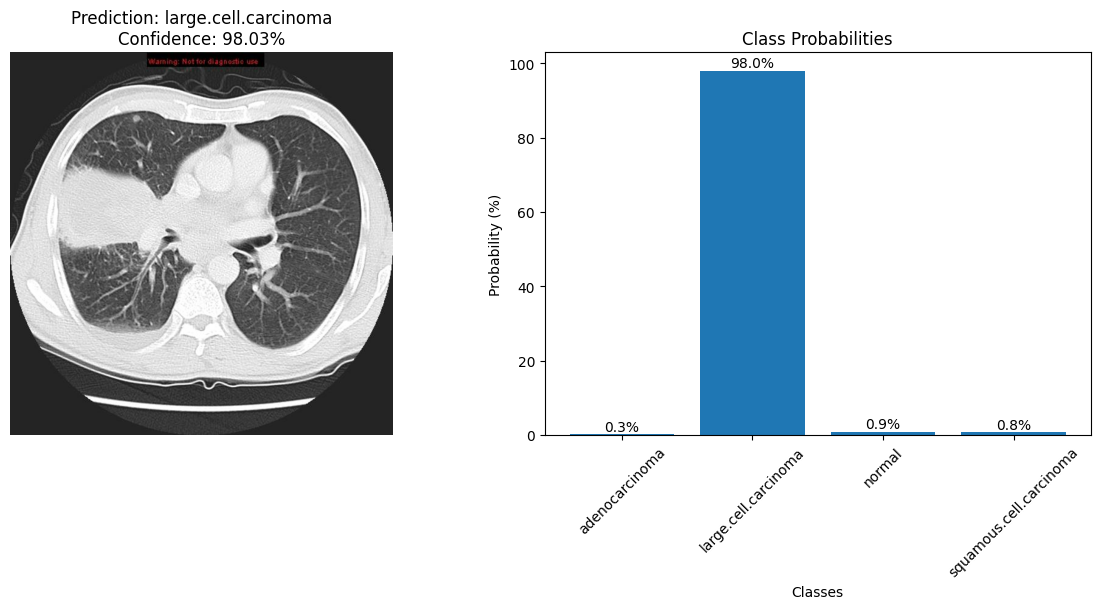


Predicted class: large.cell.carcinoma
Confidence: 98.03%

Probabilities for all classes:
adenocarcinoma: 0.26%
large.cell.carcinoma: 98.03%
normal: 0.87%
squamous.cell.carcinoma: 0.83%


In [19]:
import torch
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt

class CTScanClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CTScanClassifier, self).__init__()
        self.efficient_net = EfficientNet.from_pretrained('efficientnet-b0')
        num_ftrs = self.efficient_net._fc.in_features
        self.efficient_net._fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_ftrs, num_classes)
        )
    
    def forward(self, x):
        return self.efficient_net(x)

def load_model(checkpoint_path, num_classes):
    model = CTScanClassifier(num_classes)
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

def predict_and_plot_image(model, image_path, class_names):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    image_tensor = image_tensor.to(device)
    
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        probability, predicted_idx = torch.max(probabilities, 1)
    
    predicted_class = class_names[predicted_idx.item()]
    confidence = probability.item() * 100
    
    all_probabilities = probabilities[0].cpu().numpy() * 100
    class_probabilities = {class_name: prob for class_name, prob in zip(class_names, all_probabilities)}
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'Prediction: {predicted_class}\nConfidence: {confidence:.2f}%')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    classes = list(class_probabilities.keys())
    probs = list(class_probabilities.values())
    
    bars = plt.bar(range(len(classes)), probs)
    plt.xlabel('Classes')
    plt.ylabel('Probability (%)')
    plt.title('Class Probabilities')
    plt.xticks(range(len(classes)), classes, rotation=45)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return predicted_class, confidence, class_probabilities

def main():
    checkpoint_path = '/kaggle/working/checkpoint_epoch_19.pth'
    test_image_path = '/kaggle/input/ct-test3/test3.jpg'
    class_names = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']
    
    model = load_model(checkpoint_path, len(class_names))
    predicted_class, confidence, class_probabilities = predict_and_plot_image(model, test_image_path, class_names)
    
    print(f"\nPredicted class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}%")
    print("\nProbabilities for all classes:")
    for class_name, prob in class_probabilities.items():
        print(f"{class_name}: {prob:.2f}%")

if __name__ == "__main__":
    main()
